In [37]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.4


In [1]:
import numpy as np
import cv2
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image

D:\Project\Avaatar_assignment\avaatar_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
from diffusers.pipelines.stable_diffusion import safety_checker

def sc(self, clip_input, images) : return images, [False for i in images]

# edit the StableDiffusionSafetyChecker class so that, when called, it just returns the images and an array of True values
safety_checker.StableDiffusionSafetyChecker.forward = sc

In [17]:
# Load original image and mask image
original_img = cv2.imread('Output/bagpack/Original_Image.jpg')
mask_img = cv2.imread('Output/bagpack/mask.png', cv2.IMREAD_GRAYSCALE)

# Ensure the mask is binary (0 or 255)
_, mask_img = cv2.threshold(mask_img, 127, 255, cv2.THRESH_BINARY)

# Get user input for shifting in x and y directions (e.g., x_shift = +50, y_shift = -30)
x_shift = 50  # Horizontal shift (positive moves right)
y_shift = -30  # Vertical shift (positive moves up)

In [39]:
if original_img.shape[:2] != mask_img.shape[:2]:
    print("bc")
    mask_img = cv2.resize(mask_img, (original_img.shape[1], original_img.shape[0]))
else:
    print("by")

by


In [18]:
# Step 1: Extract the object using the mask
def extract_object(original_img, mask_img):
    object_img = cv2.bitwise_and(original_img, original_img, mask=mask_img)
    return object_img

In [19]:
# Step 2: Shift the object by applying an affine transformation
def shift_object(object_img, mask_img, x_shift, y_shift):
    rows, cols, _ = object_img.shape
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])  # Affine transform matrix
    shifted_object_img = cv2.warpAffine(object_img, M, (cols, rows))
    shifted_mask_img = cv2.warpAffine(mask_img, M, (cols, rows))
    return shifted_object_img, shifted_mask_img

In [20]:
# Extract object and shift it
object_img = extract_object(original_img, mask_img)
shifted_object_img, shifted_mask_img = shift_object(object_img, mask_img, x_shift, y_shift)
    
# Step 3: Use inpainting to remove the object from its original location
# Convert images from OpenCV (BGR) to PIL (RGB) for Stable Diffusion
original_img_pil = Image.fromarray(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
mask_img_pil = Image.fromarray(mask_img)

In [21]:
type(original_img_pil)
pil_image=original_img_pil

In [22]:
image_array = np.array(pil_image)

# Check if the image has float values (range [0, 1]) and clip values to [0, 1]
if image_array.dtype == np.float32 or image_array.dtype == np.float64:
    # Clip values to ensure no invalid values (NaN, negative, or >1 values)
    image_array = np.clip(image_array, 0, 1)
    # Scale from [0, 1] to [0, 255] and convert to uint8
    image_array = (image_array * 255).round().astype('uint8')

# If the image array is already in the integer range [0, 255], no need to scale:
elif image_array.dtype == np.uint8:
    # Optionally, ensure values are still within the range [0, 255]
    image_array = np.clip(image_array, 0, 255).astype('uint8')

# Convert the NumPy array back to a PIL image
pil_image = Image.fromarray(image_array)

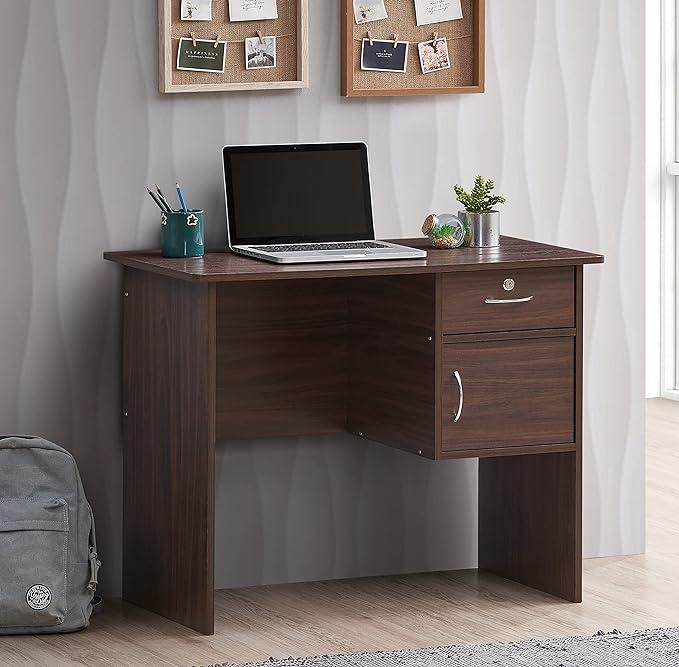

In [23]:
pil_image

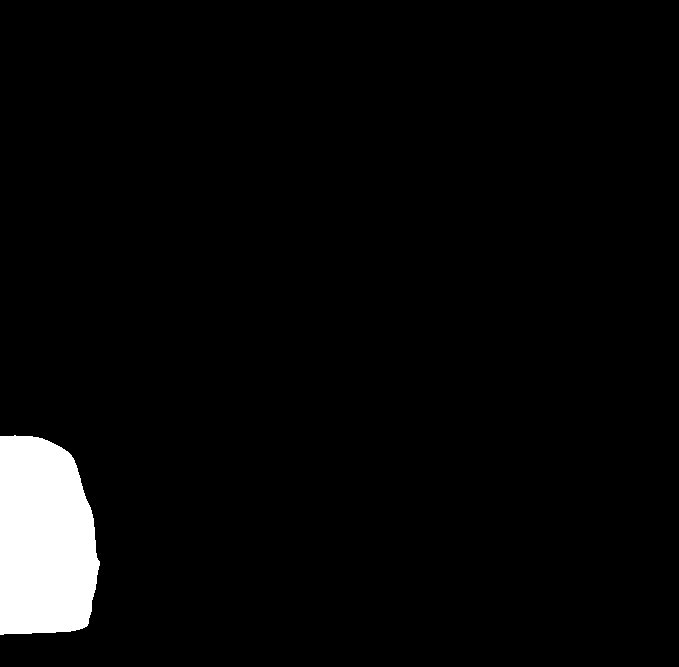

In [24]:
mask_img_pil

In [10]:
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.safety_checker = None 
pipe.to("cuda")

Fetching 13 files:   0%|                                                                        | 0/13 [00:00<?, ?it/s]D:\Project\Avaatar_assignment\avaatar_env\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\shant\.cache\huggingface\hub\models--stabilityai--stable-diffusion-2-inpainting. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-dev

StableDiffusionInpaintPipeline {
  "_class_name": "StableDiffusionInpaintPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "stabilityai/stable-diffusion-2-inpainting",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [33]:
# Load Stable Diffusion Inpainting model
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting", torch_dtype=torch.float16)
# pipe.safety_checker = None 
pipe.safety_checker = None
pipe.requires_safety_checker = False
pipe = pipe.to("cuda")  # Use GPU for better performance

unet\diffusion_pytorch_model.safetensors not found
Loading pipeline components...:   0%|                                                            | 0/7 [00:00<?, ?it/s]An error occurred while trying to fetch C:\Users\shant\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet: Error no file named diffusion_pytorch_model.safetensors found in directory C:\Users\shant\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  43%|██████████████████████▎                             | 3/7 [00:06<00:09,  2.39s/it]An error occurred while trying to fetch C:\Users\shant\.cache\huggingface\hub\models--runwayml--stable-diffusion-inpainting\snapshots\8a4288a76071f7280aedbdb3253bdb9e9d5d84bb\vae: Error no file named diffusion_pytorch_model.s

In [34]:
# Inpaint the original area where the object was located
def inpaint_area(pipe, original_img_pil, mask_img_pil, prompt=" background"):
    result = pipe(prompt=prompt, image=original_img_pil, mask_image=mask_img_pil).images[0]
    return result


In [35]:
# Perform inpainting on the area where the object was removed
inpainted_image_pil = inpaint_area(pipe, pil_image, mask_img_pil,"replace the bagpack with wall behind it")

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:27<00:00,  6.56s/it]


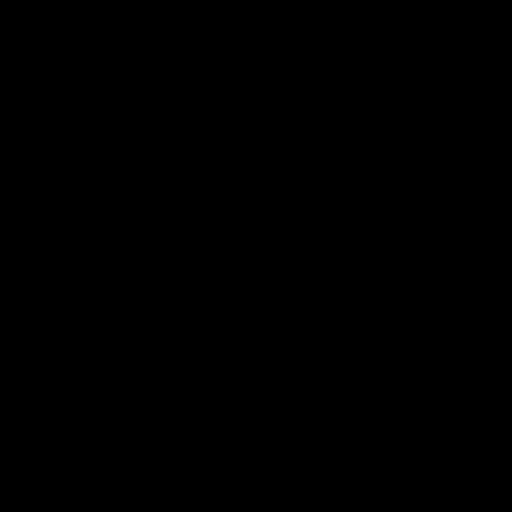

In [36]:
inpainted_image_pil

In [36]:
inpainted_image_cv2 = np.array(inpainted_image_pil)
inpainted_image_cv2 = cv2.cvtColor(inpainted_image_cv2, cv2.COLOR_RGB2BGR)
 

In [37]:

# Convert the inpainted image back to OpenCV format

# Step 4: Composite the shifted object back onto the inpainted background
# Create an inverse mask of the shifted mask
inverse_mask = cv2.bitwise_not(shifted_mask_img)

In [38]:
if len(inverse_mask.shape) == 3:
    inverse_mask = cv2.cvtColor(inverse_mask, cv2.COLOR_BGR2GRAY)

# Ensure the mask is binary (0 or 255)
_, inverse_mask = cv2.threshold(inverse_mask, 127, 255, cv2.THRESH_BINARY)

# Resize the mask to match the inpainted image dimensions, if necessary
if inverse_mask.shape != inpainted_image_cv2.shape[:2]:
    inverse_mask = cv2.resize(inverse_mask, (inpainted_image_cv2.shape[1], inpainted_image_cv2.shape[0]))

# Now use the inverse mask to remove the area from the background where the object will be placed
background_with_hole = cv2.bitwise_and(inpainted_image_cv2, inpainted_image_cv2, mask=inverse_mask)


In [39]:
# Ensure the shifted object and background have the same size
if shifted_object_img.shape[:2] != background_with_hole.shape[:2]:
    shifted_object_img = cv2.resize(shifted_object_img, (background_with_hole.shape[1], background_with_hole.shape[0]))

# Ensure both images have the same number of channels
if len(shifted_object_img.shape) == 2:  # if the object is grayscale (single channel)
    shifted_object_img = cv2.cvtColor(shifted_object_img, cv2.COLOR_GRAY2BGR)  # convert to 3-channel BGR

if len(background_with_hole.shape) == 2:  # if the background is grayscale (single channel)
    background_with_hole = cv2.cvtColor(background_with_hole, cv2.COLOR_GRAY2BGR)  # convert to 3-channel BGR

# Now add the shifted object to the new background
final_image = cv2.add(background_with_hole, shifted_object_img)

# Save or display the result
cv2.imwrite('shifted_object_composite.png', final_image)

# Optionally, display the result
# cv2.imshow('Shifted Object Composite', final_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True